- Modeling Approaches:
  - Listens.
  - Roc Curve
  - Interpretation.
  - Problems.
  - Table Showing all the tradeoffs
- Proposal model

### start

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier , ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.pipeline import make_pipeline
from credit_fraud_utils_eval import *
from credit_fraud_utils_data import scale_data , balance_data_transformation
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt
import yaml
import joblib
import os
%matplotlib inline

In [2]:
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config_path = 'config/config.yml'
config = load_config(config_path)
Random_seed = config['random_seed']

In [3]:
train_data_path = config['dataset']['train']['path']
val_data_path = config['dataset']['val']['path']

df_train = pd.read_csv(train_data_path)
df_val = pd.read_csv(val_data_path)

train_feature = config['dataset']['train_feature']
traget_feature = config['dataset']['target']

X_train = df_train[train_feature]
y_train = df_train[traget_feature]

X_val = df_val[train_feature]
y_val = df_val[traget_feature]

In [4]:
report_val = {}
model_comparison = {}

In [5]:
y_train.value_counts()

Class
0    170579
1       305
Name: count, dtype: int64

In [6]:
balance_type = "over" # smote over 

ratio_minority= 0.05       

sampling_strategy = ratio_minority

X_train, y_train = balance_data_transformation(X_train, y_train, balance_type=balance_type, sampling_strategy=sampling_strategy, k=10,  random_state=Random_seed)

In [7]:
y_train.value_counts()

Class
0    170579
1      8528
Name: count, dtype: int64

### Random Forest

<!-- rf = RandomForestClassifier(
    n_estimators=600,   
    min_samples_leaf = 2, 
    min_samples_split = 4,
    class_weight={0: 0.25 , 1: 1},   
    n_jobs=-1,              
    random_state=Random_seed  
)
rf.fit(X_train, y_train) -->

In [14]:
# rf = RandomForestClassifier(
#     n_estimators=800,
#     min_samples_leaf=15,
#     min_samples_split=15,
#     bootstrap=True, 
#     # class_weight= {0: 0.5, 1: 1.0},
#     n_jobs=-1,              
#     random_state=Random_seed  
# )

# rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=15, min_samples_split=15,
                       n_estimators=800, n_jobs=-1, random_state=16)

In [8]:

param_grid = {
    'n_estimators': [500, 700 , 800],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [2, 10, 15, 20],
    'bootstrap': [True],
    'class_weight': ['balanced', 'balanced_subsample', {0: 0.5, 1: 1.0}],
}

# Define the StratifiedKFold cross-validator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the GridSearchCV with f1 score for the positive class
scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1, random_state=Random_seed),
    param_grid=param_grid,
    scoring=scorer,
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)


print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (f1 score for positive class): ", grid_search.best_score_)

# Evaluate the best model on the test data
rf = grid_search.best_estimator_
y_pred = rf.predict(X_val)

# Print the classification report and F1 score for the positive class
print("Classification report:\n", classification_report(y_val, y_pred))
print("F1 Score (positive class): ", f1_score(y_val, y_pred, pos_label=1))


Fitting 5 folds for each of 108 candidates, totalling 540 fits


d:\Repo\New folder\2 Credit Card Fraud Detection\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Random Forest Train Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.99975   0.99987    170579
           1    0.99498   1.00000   0.99749      8528

    accuracy                        0.99976    179107
   macro avg    0.99749   0.99987   0.99868    179107
weighted avg    0.99976   0.99976   0.99976    179107



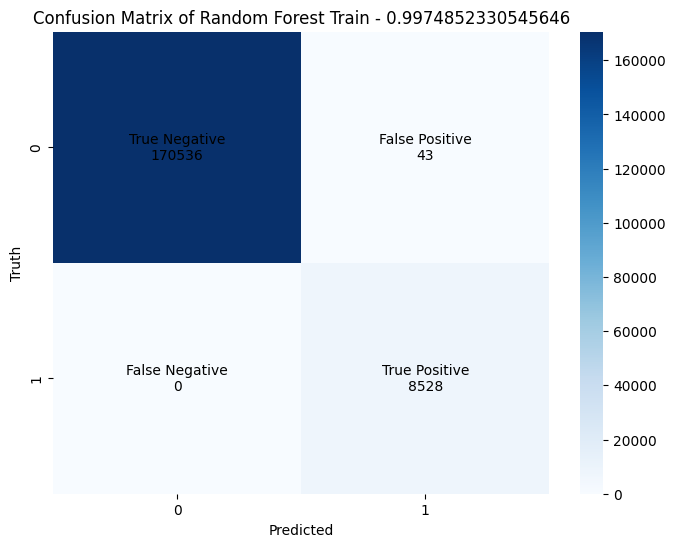

In [ ]:
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)

_ = eval_classification_report_confusion_matrix(y_pred=y_train_pred, y_true=y_train, title='Random Forest Train')

* False Positive ().
* False Negative (Number of fraud transctions we can't catch).

d:\Repo\New folder\2 Credit Card Fraud Detection\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Random Forest Val Classification Report
              precision    recall  f1-score   support

           0    0.99975   0.99979   0.99977     56870
           1    0.86364   0.84444   0.85393        90

    accuracy                        0.99954     56960
   macro avg    0.93170   0.92212   0.92685     56960
weighted avg    0.99954   0.99954   0.99954     56960



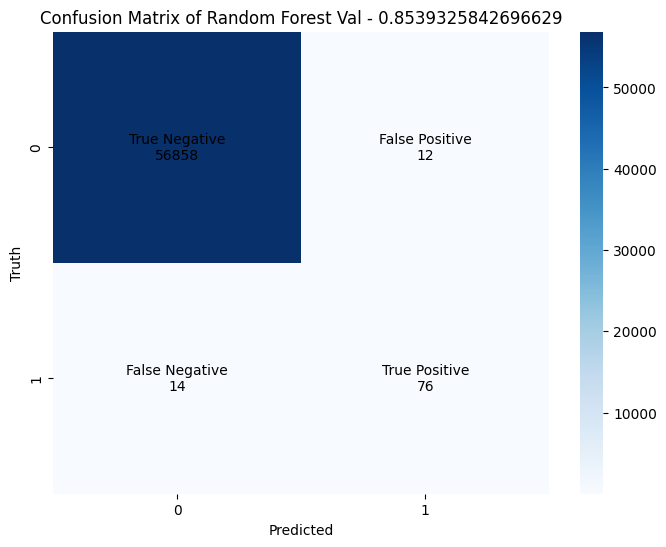

In [ ]:
y_val_pred = rf.predict(X_val)
report_val = eval_classification_report_confusion_matrix(y_pred=y_val_pred,y_true=y_val, title='Random Forest Val')
# model_comparison = eval_update_model_stats(model_comparison, 'Random Forest',  report_val)

Optimal Threshold: 0.9777098265316815 F1 Score: 0.9989457654913905


d:\Repo\New folder\2 Credit Card Fraud Detection\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Random Forest Val with optimal threshold Classification Report
              precision    recall  f1-score   support

           0    0.99937   0.99988   0.99962     56870
           1    0.88525   0.60000   0.71523        90

    accuracy                        0.99925     56960
   macro avg    0.94231   0.79994   0.85743     56960
weighted avg    0.99919   0.99925   0.99917     56960



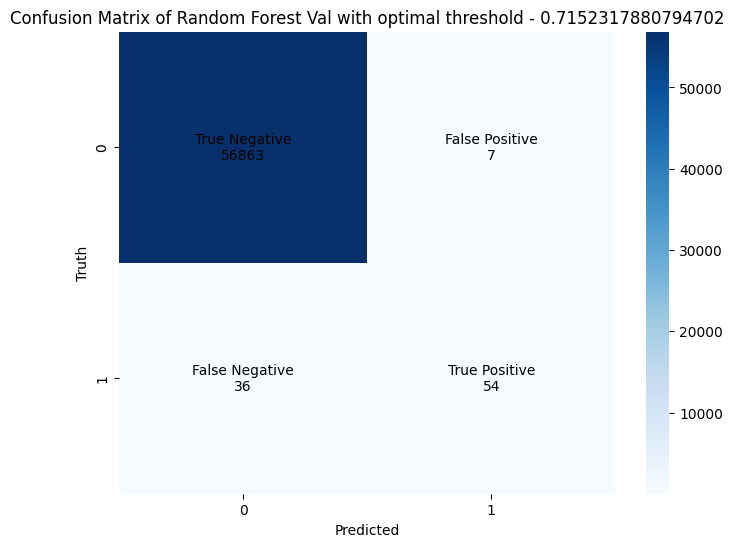

In [ ]:
from credit_fraud_utils_eval import eval_best_threshold , eval_predict_with_threshold


y_train_pred_proba = rf.predict_proba(X_train)[:,1]
optimal_threshold , f1_scores = eval_best_threshold(y_pred=y_train_pred_proba,y_true=y_train)

y_val_pred = eval_predict_with_threshold(model=rf, x=X_val, threshold=optimal_threshold)
report_val = eval_classification_report_confusion_matrix(y_pred=y_val_pred,y_true=y_val, title='Random Forest Val with optimal threshold')

# model_comparison = eval_update_model_stats(model_comparison, 'Random Forest optimal threshold',  report_val)


* we have two goal minmize f-socer of postive class and False Negative.
* Random Forest with optimle threshold is butter.
    * becase its Minimizing false negative

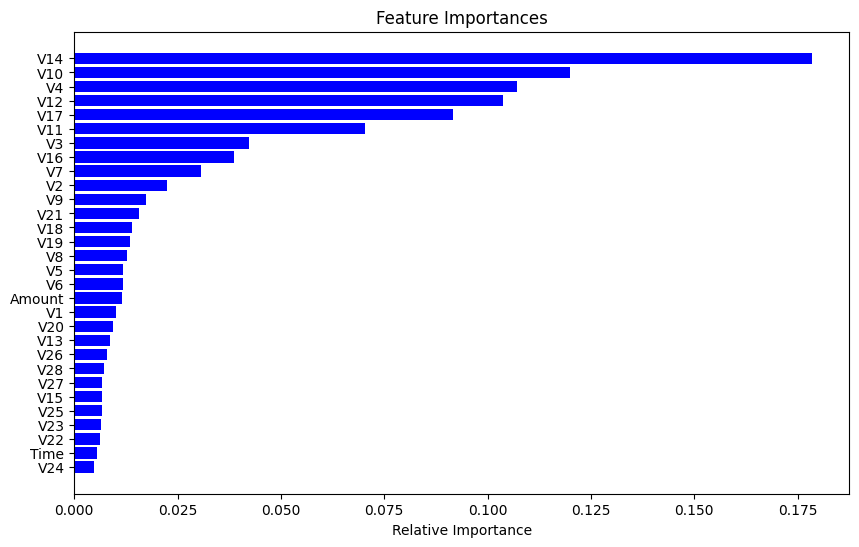

In [ ]:
importances = rf.feature_importances_
feature_names = X_val.columns

indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### AdaBoost

In [ ]:
adboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), # use a stump tree as weak learner
                   n_estimators=500,
                   learning_rate=0.01,
                   algorithm='SAMME',
                   random_state=Random_seed)

adboost.fit(X_train, y_train)

In [ ]:
y_train_pred = adboost.predict(X_train)

_ = eval_classification_report_confusion_matrix(y_pred=y_train_pred,y_true=y_train , title='AdaBoost Train')

In [ ]:
y_val_pred = adboost.predict(X_val)

report_val = eval_classification_report_confusion_matrix(y_pred=y_val_pred,y_true=y_val, title='AdaBoost Val')
model_comparison = eval_update_model_stats(model_comparison, 'AdaBoost',  report_val)


In [ ]:
y_train_pred_proba = adboost.predict_proba(X_train)[:,1]
optimal_threshold , f1_scores = eval_best_threshold(y_pred=y_train_pred_proba,y_true=y_train)

y_val_pred = eval_predict_with_threshold(model=rf, x=X_val, threshold=optimal_threshold)
report_val = eval_classification_report_confusion_matrix(y_pred=y_val_pred,y_true=y_val, title='AdaBoost Validation with optimal threshold')
model_comparison = eval_update_model_stats(model_comparison, 'AdaBoost optimal threshold',  report_val)


### Extra Tree

In [ ]:
extra_trees = ExtraTreesClassifier(
                    n_estimators=500, 
                    max_leaf_nodes=10,
                    n_jobs=-1, 
                    random_state=42
                    )


extra_trees.fit(X_train, y_train)

In [ ]:
y_train_pred = extra_trees.predict(X_train)
_ = eval_classification_report_confusion_matrix(y_pred=y_train_pred,y_true=y_train, title='Extra Trees Train')

In [ ]:
print('Validation Classification Report')
y_val_pred = extra_trees.predict(X_val)
report_val = eval_classification_report_confusion_matrix(y_pred=y_val_pred,y_true=y_val, title='Extra Trees Val')
model_comparison = eval_update_model_stats(model_comparison, 'Extra Trees', report_val)

In [ ]:
y_train_pred_proba = extra_trees.predict_proba(X_train)[:,1]

optimal_threshold , f1_scores = eval_best_threshold(y_pred=y_train_pred_proba,y_true=y_train)

y_val_pred = eval_predict_with_threshold(model=extra_trees, x=X_val, threshold=optimal_threshold)
report_val = eval_classification_report_confusion_matrix(y_pred=y_val_pred,y_true=y_val, title='Extra Trees Val with optimal threshold')
model_comparison = eval_update_model_stats(model_comparison, 'Extra Trees optimal threshold',  report_val)

### Xgboost

In [ ]:
xgboost = GradientBoostingClassifier(
    n_estimators=600,
    learning_rate=0.01,
    max_depth=3,
    n_iter_no_change=10,
    random_state=Random_seed
)

xgboost.fit(X_train, y_train)

In [ ]:
y_train_pred = xgboost.predict(X_train)
_ = eval_classification_report_confusion_matrix(y_pred=y_train_pred, y_true=y_train, title='XGBoost Train')

In [ ]:
y_val_pred = xgboost.predict(X_val)
report_val = eval_classification_report_confusion_matrix(y_pred=y_val_pred, y_true=y_val, title='XGBoost Val')
model_comparison = eval_update_model_stats(model_comparison, 'XGBoost', report_val)

In [ ]:
y_train_pred_proba = xgboost.predict_proba(X_train)[:,1]

optimal_threshold , f1_scores = eval_best_threshold(y_pred=y_train_pred_proba,y_true=y_train)

y_val_pred = eval_predict_with_threshold(model=xgboost, x=X_val, threshold=optimal_threshold)
report_val = eval_classification_report_confusion_matrix(y_pred=y_val_pred,y_true=y_val, title='XGBoost Val with optimal threshold')
model_comparison = eval_update_model_stats(model_comparison, 'XGBoost optimal threshold',  report_val)

In [ ]:
# Comparison Ensemble models
model_comparison = pd.DataFrame(model_comparison)
model_comparison.T

* Adabost and Random Forest outperform another models.
* Model with optimal threshold outperform models with Default theshold. 

### Logistic Regression


In [51]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [52]:
class_count = df_train["Class"].value_counts().to_dict()

total_samples = sum(class_count.values())
balanced_cweights = {cls: total_samples / (len(class_count) * count) for cls, count in class_count.items()}

balanced_cweights

{0: 0.5008940139173051, 1: 280.1377049180328}

Best Hyperparameters: {'C': 0.01, 'class_weight': {0: 0.25, 1: 1}, 'max_iter': 300, 'penalty': 'l2'}
Logistic Regression Train Classification Report
              precision    recall  f1-score   support

           0    0.99957   0.99976   0.99966    170579
           1    0.84926   0.75738   0.80069       305

    accuracy                        0.99933    170884
   macro avg    0.92442   0.87857   0.90018    170884
weighted avg    0.99930   0.99933   0.99931    170884



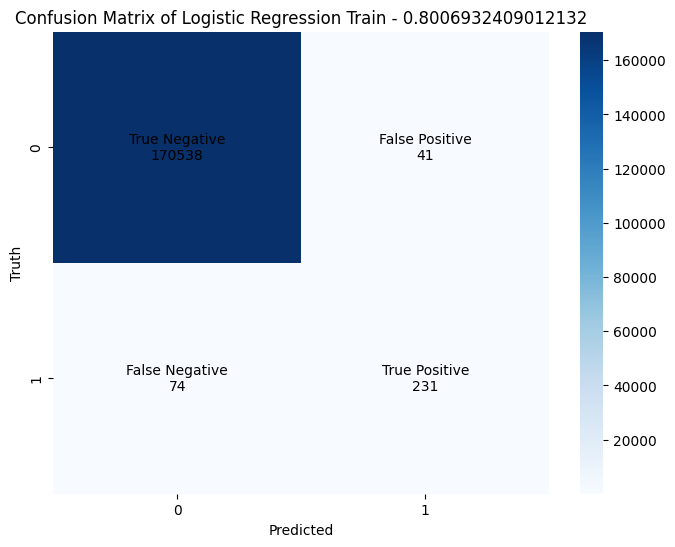

In [73]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2', None],
    'class_weight': ['balanced' , None , {0: 0.25 , 1: 1} , {0: 0.75 , 1: 4} , {0: 1 , 1: 5}],
    'max_iter': [300, 500, 800, 1000]
}
  
lr = LogisticRegression()

scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(lr, param_grid,cv=4, scoring=scorer , n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_lr = LogisticRegression(
                             **best_params,
                             random_state=Random_seed
)

best_lr.fit(X_train_scaled, y_train)

y_pred = best_lr.predict(X_train_scaled)

_ = eval_classification_report_confusion_matrix(y_pred=y_pred,y_true=y_train, title='Logistic Regression Train')

Logistic Regression Val Classification Report
              precision    recall  f1-score   support

           0    0.99961   0.99905   0.99933     56870
           1    0.55738   0.75556   0.64151        90

    accuracy                        0.99867     56960
   macro avg    0.77849   0.87730   0.82042     56960
weighted avg    0.99891   0.99867   0.99877     56960



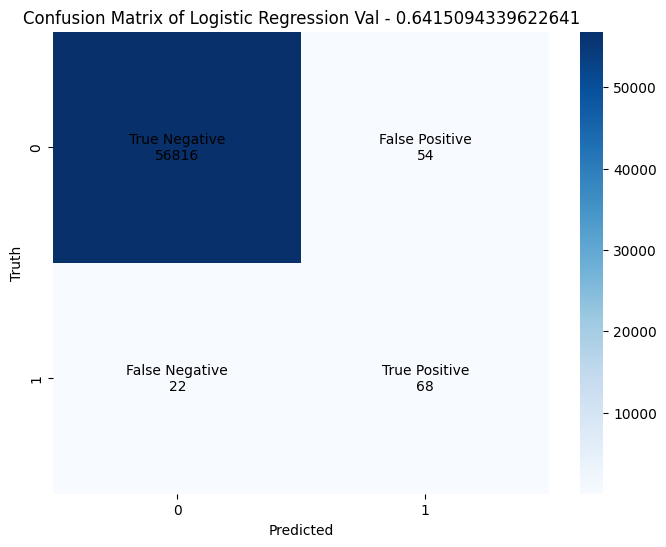

In [84]:
y_pred = best_lr.predict(X_val_scaled)

report_val = eval_classification_report_confusion_matrix(y_pred=y_pred,y_true=y_val, title='Logistic Regression Val')
model_comparison = eval_update_model_stats(model_comparison, 'Logistic Regression', report_val)

Optimal Threshold: 0.6561918027088339 F1 Score: 0.6801242236024846
Logistic Regression Val with optimal threshold Classification Report
              precision    recall  f1-score   support

           0    0.99958   0.99921   0.99939     56870
           1    0.59459   0.73333   0.65672        90

    accuracy                        0.99879     56960
   macro avg    0.79709   0.86627   0.82805     56960
weighted avg    0.99894   0.99879   0.99885     56960



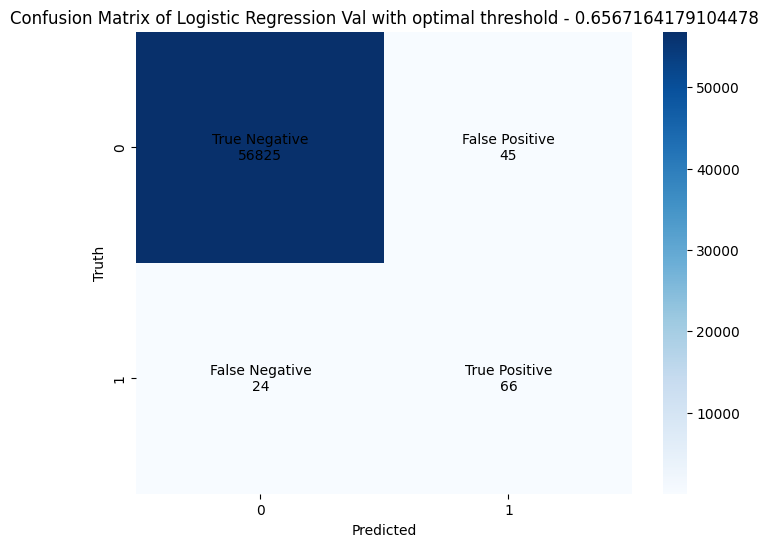

In [85]:
y_pred_proba = best_lr.predict_proba(X_train_scaled)[:,1]

optimal_threshold , f1_scores = eval_best_threshold(y_pred=y_pred_proba,y_true=y_train)

y_val_pred = eval_predict_with_threshold(model=best_lr, x=X_val_scaled, threshold=optimal_threshold)

report_val = eval_classification_report_confusion_matrix(y_pred=y_val_pred,y_true=y_val, title='Logistic Regression Val with optimal threshold')
model_comparison = eval_update_model_stats(model_comparison, 'Logistic Regression optimal threshold',  report_val)

### Neural Network


#### Sklearn implementation 

Number of parameters in each layer: [6000, 3200, 16]
Total number of parameters: 9216
MLP Train Classification Report
              precision    recall  f1-score   support

           0    0.99951   0.99998   0.99975    170579
           1    0.98230   0.72787   0.83616       305

    accuracy                        0.99949    170884
   macro avg    0.99091   0.86392   0.91795    170884
weighted avg    0.99948   0.99949   0.99945    170884



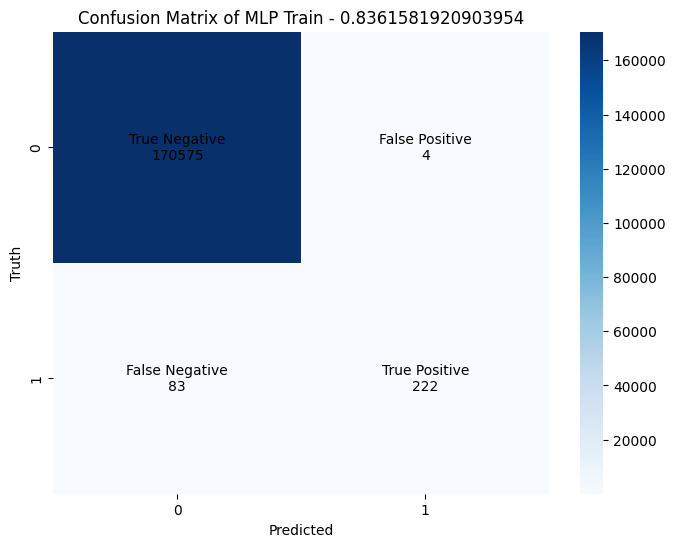

In [79]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# param_grid = {
#     'activation': ['relu'],
#     'hidden_layer_sizes': [(20 , 15 , 20), (20 , 15 , 15 , 15), (30 , 15 , 15 , 10)],
#     'solver': ['adam'],
#     'batch_size': [32 , 64 , 128],
#     'learning_rate_init': [0.001, 0.01, 0.1],
#     'alpha': [0.001, 0.01, 0.025],
#     'max_iter': [500, 800, 1000, 2000],
#     'random_state': [Random_seed]
# }
  
# MLP_CV = MLPClassifier()
# scorer = make_scorer(f1_score, pos_label=1)
# grid_search = GridSearchCV(MLP_CV, param_grid,cv=4, scoring=scorer , n_jobs=-1)
# grid_search.fit(X_train_scaled, y_train)
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

MLP = MLPClassifier(
    hidden_layer_sizes=(200, 16),
    activation = 'relu',
    solver = 'adam',
    batch_size = 32,
    learning_rate_init = 0.004,
    max_iter = 1000,
    random_state = Random_seed
)

MLP.fit(X_train_scaled, y_train)

parameter_counts = [layer.size for layer in MLP.coefs_]
print("Number of parameters in each layer:", parameter_counts)
print("Total number of parameters:", sum(parameter_counts))

y_train_pred = MLP.predict(X_train_scaled)
_ = eval_classification_report_confusion_matrix(y_pred=y_train_pred, y_true=y_train, title='MLP Train')

MLP Val Classification Report
              precision    recall  f1-score   support

           0    0.99949   0.99993   0.99971     56870
           1    0.93846   0.67778   0.78710        90

    accuracy                        0.99942     56960
   macro avg    0.96898   0.83885   0.89340     56960
weighted avg    0.99939   0.99942   0.99937     56960



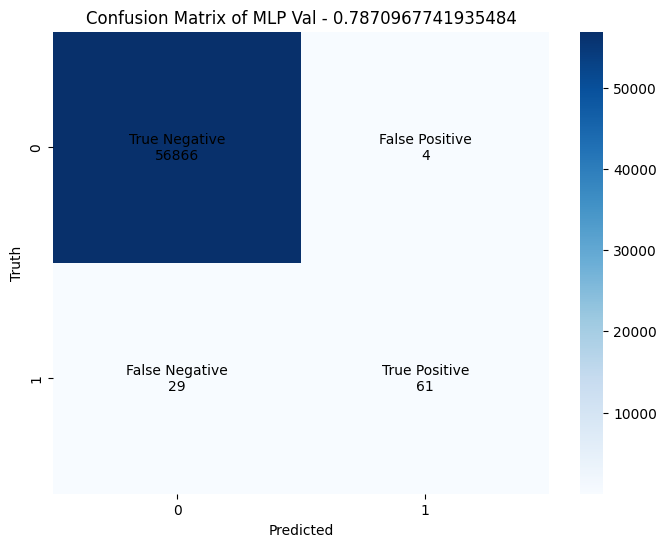

In [80]:
y_train_pred = MLP.predict(X_val_scaled)
report_val = eval_classification_report_confusion_matrix(y_pred=y_train_pred,y_true=y_val, title='MLP Val')
model_comparison = eval_update_model_stats(model_comparison, 'MLP', report_val)

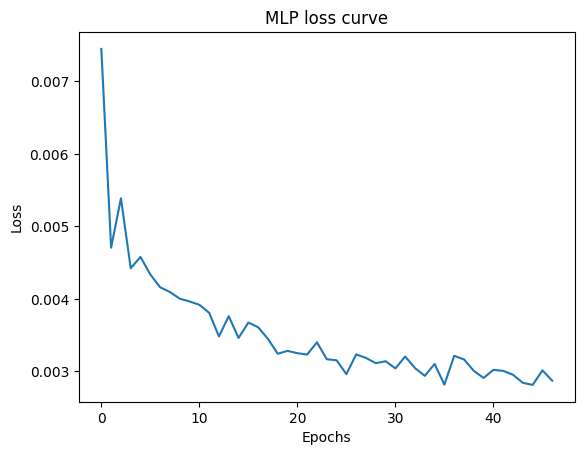

In [81]:
plt.plot(MLP.loss_curve_)
plt.title('MLP loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Optimal Threshold: 0.05480338830742529 F1 Score: 0.8727858293075684
MLP Val with optimal threshold Classification Report
              precision    recall  f1-score   support

           0    0.99968   0.99967   0.99967     56870
           1    0.79121   0.80000   0.79558        90

    accuracy                        0.99935     56960
   macro avg    0.89545   0.89983   0.89763     56960
weighted avg    0.99935   0.99935   0.99935     56960



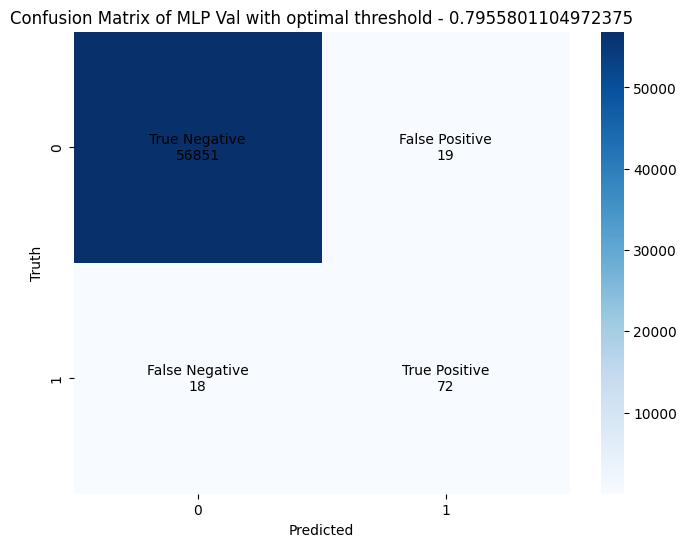

In [82]:
y_pred_proba = MLP.predict_proba(X_train_scaled)[:,1]

optimal_threshold , f1_scores = eval_best_threshold(y_pred=y_pred_proba,y_true=y_train)

y_val_pred = eval_predict_with_threshold(model=MLP, x=X_val_scaled, threshold=optimal_threshold)

report_val = eval_classification_report_confusion_matrix(y_pred=y_val_pred,y_true=y_val, title='MLP Val with optimal threshold')
model_comparison = eval_update_model_stats(model_comparison, 'MLP optimal threshold',  report_val)


In [83]:
pd.DataFrame(model_comparison).T

,F1 Score Positive class,F1 Score Negative class,Precision Positive class,Recall Positive class,F1 Score Average,AUC Precision Recal
Logistic Regression,0.748387,0.999657,0.892308,0.644444,0.874022,0.767077
Logistic Regression optimal threshold,0.792683,0.999701,0.878378,0.722222,0.896192,0.798940
MLP,0.787097,0.999710,0.938462,0.677778,0.893403,0.806794
MLP optimal threshold,0.795580,0.999675,0.791209,0.800000,0.897627,0.794182
Voting,0.825581,0.999736,0.865854,0.788889,0.912659,0.825958
Voting optimal threshold,0.813187,0.999701,0.804348,0.822222,0.906444,0.811845
Random Forest,0.836158,0.999745,0.850575,0.822222,0.917952,0.834959


#### pytorch implemention

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.utils.class_weight import compute_class_weight

# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


# class FraudDetectionNN(nn.Module):
#     def __init__(self):
#         super(FraudDetectionNN, self).__init__()
#         self.hidden1 = nn.Linear(X_train.shape[1], 32)
#         self.hidden2 = nn.Linear(32, 15)
#         self.output = nn.Linear(15, 1)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.hidden1(x))
#         x = self.relu(self.hidden2(x))
#         x = torch.sigmoid(self.output(x))
#         return x


# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])


# model = FraudDetectionNN()
# optimizer = optim.Adam(model.parameters(), lr=0.01)


# num_epochs = 5
# batch_size = 32

# for epoch in range(num_epochs):
#     model.train()
#     permutation = torch.randperm(X_train_tensor.size()[0])

#     for i in range(0, X_train_tensor.size()[0], batch_size):
#         indices = permutation[i:i + batch_size]
#         batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

#         optimizer.zero_grad()
#         outputs = model(batch_x)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()

#     if (epoch + 1) % 100 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


# model.eval()
# with torch.no_grad():
#     y_train_pred = model(X_train_tensor).round().detach().tolist()

# _ = eval_classification_report_confusion_matrix(y_pred=y_train_pred,y_true=y_train)

In [ ]:
# X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
# y_train_pred = model(X_val_tensor).round().detach().tolist()

# report_val = eval_classification_report_confusion_matrix(y_pred=y_train_pred,y_true=y_val, title='NN Val')
# model_comparison = update_model_eval_stats(model_comparison, 'NN', report_val)

In [ ]:
# Comparison Gradient Based Models
model_comparison[['MLP',  'Logistic Regression']].T

## KNN

In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [i for i in range(1, 10, 5)] }

scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

X_train = np.array(X_train)
best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_train)
_ = eval_classification_report_confusion_matrix(y_pred=y_pred,y_true=y_train)

* KNN overfiting and if we increate the inti value will inderfit

In [ ]:
y_pred = best_knn.predict(X_val)

report_val = eval_classification_report_confusion_matrix(y_pred=y_pred,y_true=y_val, title='KNN Val')
model_comparison = eval_update_model_stats(model_comparison, 'KNN', report_val)

## VotingClassifier


Voting Train Classification Report
              precision    recall  f1-score   support

           0    0.99969   0.99986   0.99977    170579
           1    0.91304   0.82623   0.86747       305

    accuracy                        0.99955    170884
   macro avg    0.95637   0.91304   0.93362    170884
weighted avg    0.99953   0.99955   0.99954    170884



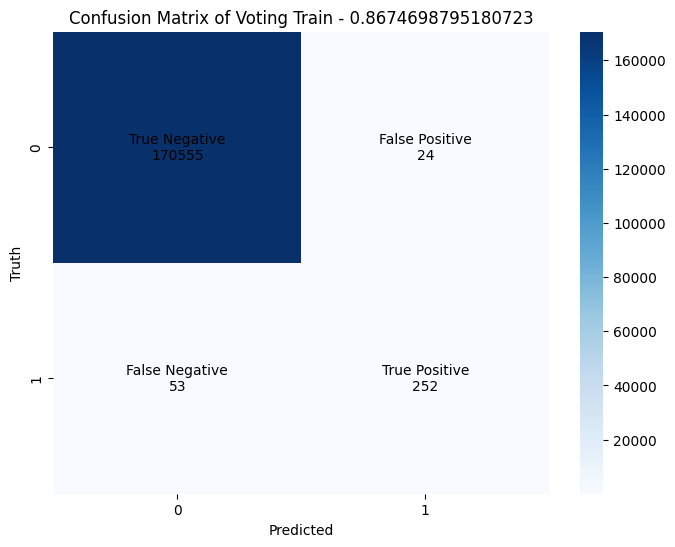

In [96]:
from mlxtend.classifier import EnsembleVoteClassifier 

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

voting_model = EnsembleVoteClassifier(
        clfs=[
            make_pipeline(scaler, best_lr),
            make_pipeline(scaler, MLP),
            rf,
        ],
        voting='soft',
        weights=[1, 1, 2],
        fit_base_estimators=False,
        use_clones=False
)


y_pred = voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_train)

_ = eval_classification_report_confusion_matrix(y_pred=y_pred,y_true=y_train, title='Voting Train')

Voting Val Classification Report
              precision    recall  f1-score   support

           0    0.99967   0.99981   0.99974     56870
           1    0.86585   0.78889   0.82558        90

    accuracy                        0.99947     56960
   macro avg    0.93276   0.89435   0.91266     56960
weighted avg    0.99945   0.99947   0.99946     56960



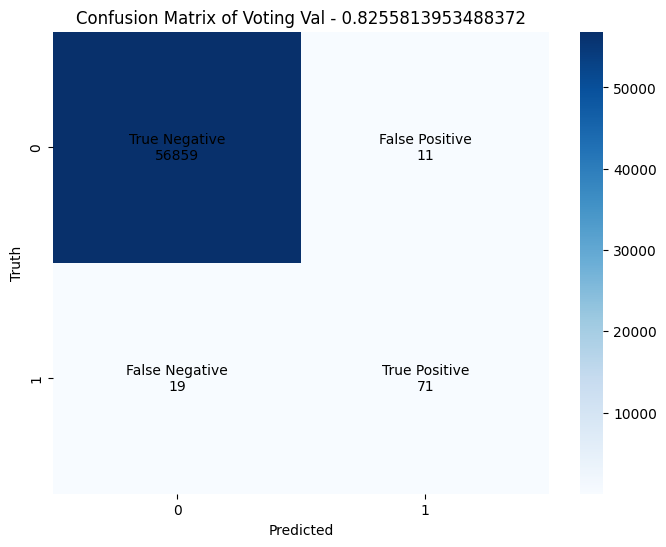

In [97]:
y_pred = voting_model.predict(X_val)

report_val = eval_classification_report_confusion_matrix(y_pred=y_pred,y_true=y_val, title='Voting Val')
model_comparison = eval_update_model_stats(model_comparison, 'Voting', report_val)

Optimal Threshold: 0.3010767093302928 F1 Score: 0.9088191330343797
Voting Val with optimal threshold Classification Report
              precision    recall  f1-score   support

           0    0.99972   0.99974   0.99973     56870
           1    0.83146   0.82222   0.82682        90

    accuracy                        0.99946     56960
   macro avg    0.91559   0.91098   0.91327     56960
weighted avg    0.99945   0.99946   0.99945     56960



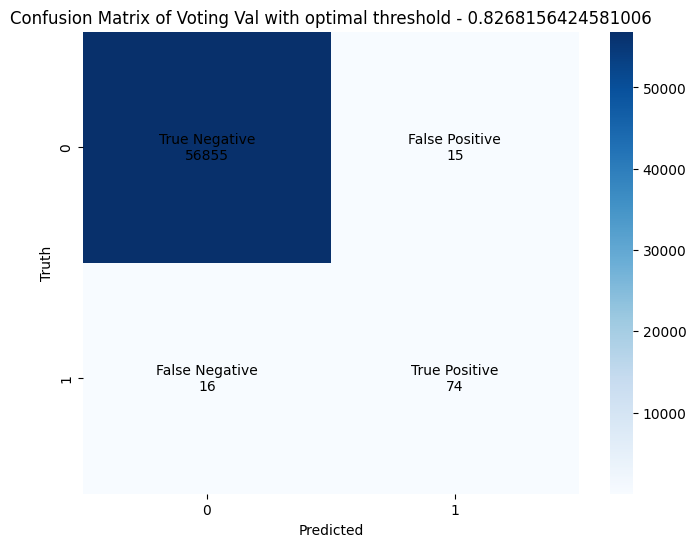

In [98]:
y_pred = voting_model.predict_proba(X_train)[:,1]

optimal_threshold , f1_scores = eval_best_threshold(y_pred=y_pred,y_true=y_train)

y_pred = eval_predict_with_threshold(model=voting_model, x=X_val, threshold=optimal_threshold)

report_val = eval_classification_report_confusion_matrix(y_pred=y_pred,y_true=y_val, title='Voting Val with optimal threshold')
model_comparison = eval_update_model_stats(model_comparison, 'Voting optimal threshold',  report_val)

In [99]:
model_comparison = pd.DataFrame(model_comparison)
model_comparison.T

,F1 Score Positive class,F1 Score Negative class,Precision Positive class,Recall Positive class,F1 Score Average,AUC Precision Recal
Logistic Regression,0.641509,0.999332,0.557377,0.755556,0.820421,0.655079
Logistic Regression optimal threshold,0.656716,0.999393,0.594595,0.733333,0.828055,0.662595
MLP,0.787097,0.999710,0.938462,0.677778,0.893403,0.806794
MLP optimal threshold,0.795580,0.999675,0.791209,0.800000,0.897627,0.794182
Voting,0.825581,0.999736,0.865854,0.788889,0.912659,0.825958
Voting optimal threshold,0.826816,0.999727,0.831461,0.822222,0.913272,0.825402
Random Forest,0.840909,0.999754,0.860465,0.822222,0.920331,0.839904
Random Forest optimal threshold,0.832370,0.999745,0.867470,0.800000,0.916057,0.832313


In [95]:
model_comparison.to_csv('model_comparison(Original DataSet).csv', index=False)